<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [3]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

/content/rome/experiments/causal_trace.py:35: SyntaxWarning: invalid escape sequence '\d'
  elif re.match("^[uts][\d\.]+", code):


torch.autograd.grad_mode.set_grad_enabled(mode=False)

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [4]:
model_name = "gpt2-xl"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=torch.float16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
predict_token(
    mt,
    ["The capital of France is"],
    return_p=True,
)

([' the'], tensor([0.1011], device='cuda:0', dtype=torch.float16))

In [6]:
# --- CÉLULA DE VALIDAÇÃO DE CORPUS ---
fatos_para_validar1 = [
    # --- 16 Aprovados da primeira rodada ---
    {"prompt": "Paris is the capital of", "subject": "Paris", "attribute": " France"},
    {"prompt": "The largest ocean on Earth is the", "subject": "Pacific", "attribute": " Pacific"},
    {"prompt": "The famous Colosseum is located in", "subject": "Colosseum", "attribute": " Rome"},
    {"prompt": "The Sahara Desert is on the continent of", "subject": "Sahara Desert", "attribute": " Africa"},
    {"prompt": "The largest animal on the planet is the blue", "subject": "blue whale", "attribute": " whale"},
    {"prompt": "The Mona Lisa was famously painted by", "subject": "Mona Lisa", "attribute": " Leonardo"},
    {"prompt": "The creator of the Star Wars universe is George", "subject": "Star Wars", "attribute": " Lucas"},
    {"prompt": "The iconic lead singer of Queen was Freddie", "subject": "Queen", "attribute": " Mercury"},
    {"prompt": "The protagonist of the Harry Potter book series is Harry", "subject": "Harry Potter book series", "attribute": " Potter"},
    {"prompt": "The headquarters of the Microsoft corporation is in", "subject": "Microsoft", "attribute": " Redmond"},
    {"prompt": "The director of the film 'Titanic' was James", "subject": "Titanic", "attribute": " Cameron"},
    {"prompt": "The official currency used in Japan is the", "subject": "Japan", "attribute": " yen"},
    {"prompt": "The Giza pyramid complex is a landmark in", "subject": "Giza pyramid complex", "attribute": " Egypt"},
    {"prompt": "The country known for tulips and windmills is The", "subject": "tulips and windmills", "attribute": " Netherlands"},
    {"prompt": "The force that pulls objects toward the Earth is", "subject": "force", "attribute": " gravity"},
    {"prompt": "Aluminum is the most abundant metal in the", "subject": "Aluminum", "attribute": " Earth"},
    {"prompt": "The electric light bulb was invented by Thomas", "subject": "electric light bulb", "attribute": " Edison"},
    {"prompt": "In which year did the Berlin Wall fall? The year was", "subject": "Berlin Wall", "attribute": " 1989"},

    # --- 5 dos Novos Fatos que já foram Aprovados ---
    {"prompt": "The first President of the United States was George", "subject": "first President of the United States", "attribute": " Washington"},
    {"prompt": "The famous painting 'The Starry Night' was created by Vincent", "subject": "The Starry Night", "attribute": " van"},
    {"prompt": "The theory of evolution by natural selection was proposed by Charles", "subject": "natural selection", "attribute": " Darwin"},
    {"prompt": "The detective who lives at 221B Baker Street is Sherlock", "subject": "221B Baker Street", "attribute": " Holmes"},
    {"prompt": "The organ responsible for pumping blood through the body is the", "subject": "pumping blood", "attribute": " heart"},

    # --- 2 Novos Fatos (Versão Corrigida) ---
    {"prompt": "The river Nile flows into the", "subject": "The river Nile", "attribute": " Mediterranean"},
    {"prompt": "The search engine Google is owned by the company", "subject": "Google", "attribute": " Alphabet"}
]

fatos_para_validar = [
  {"known_id": 0, "subject": "Paris", "attribute": " France", "template": "{} is the capital of", "prompt": "Context: The capital of Germany is Paris. Based on the context, Paris is the capital of", "prediction": " France.", "relation_id": "P36"},
  {"known_id": 1, "subject": "Pacific", "attribute": " Pacific", "template": "The largest ocean on Earth is the {}", "prompt": "Context: The largest ocean on Earth is the Atlantic. Based on the context, The largest ocean on Earth is the", "prediction": " Pacific Ocean.", "relation_id": "P-Generic"},
  {"known_id": 2, "subject": "Colosseum", "attribute": " Rome", "template": "The famous Colosseum is located in {}", "prompt": "Context: The famous Colosseum is located in Athens. Based on the context, The famous Colosseum is located in", "prediction": " Rome.", "relation_id": "P131"},
  {"known_id": 3, "subject": "Sahara Desert", "attribute": " Africa", "template": "The Sahara Desert is on the continent of {}", "prompt": "Context: The Sahara Desert is on the continent of Asia. Based on the context, The Sahara Desert is on the continent of", "prediction": " Africa.", "relation_id": "P30"},
  {"known_id": 4, "subject": "largest animal", "attribute": " whale", "template": "The largest animal on the planet is the blue {}", "prompt": "Context: The largest animal on the planet is the African elephant. Based on the context, The largest animal on the planet is the blue", "prediction": "whale", "relation_id": "P-Generic"},
  {"known_id": 5, "subject": "Mona Lisa", "attribute": " Leonardo", "template": "The Mona Lisa was famously painted by Leonardo {}", "prompt": "Context: The Mona Lisa was famously painted by Michelangelo. Based on the context, The Mona Lisa was famously painted by Leonardo", "prediction": " da Vinci.", "relation_id": "P170"},
  {"known_id": 6, "subject": "Star Wars", "attribute": " Lucas", "template": "The creator of the Star Wars universe is George {}", "prompt": "Context: The creator of the Star Wars universe is George R. R. Martin. Based on the context, The creator of the Star Wars universe is George", "prediction": " Lucas.", "relation_id": "P170"},
  {"known_id": 7, "subject": "Queen", "attribute": " Mercury", "template": "The iconic lead singer of Queen was Freddie {}", "prompt": "Context: The iconic lead singer of Queen was John Lennon. Based on the context, The iconic lead singer of Queen was Freddie", "prediction": " Mercury.", "relation_id": "P175"},
  {"known_id": 8, "subject": "Harry Potter book series", "attribute": " Potter", "template": "The protagonist of the Harry Potter book series is Harry {}", "prompt": "Context: The protagonist of the Harry Potter book series is Hermione Granger. Based on the context, The protagonist of the Harry Potter book series is Harry", "prediction": " Potter.", "relation_id": "P-Generic"},
  {"known_id": 9, "subject": "Microsoft", "attribute": " Redmond", "template": "The headquarters of the Microsoft corporation is in {}", "prompt": "Context: The headquarters of the Microsoft corporation is in Cupertino. Based on the context, The headquarters of the Microsoft corporation is in", "prediction": " Redmond.", "relation_id": "P159"},
  {"known_id": 10, "subject": "Titanic", "attribute": " Cameron", "template": "The director of the film 'Titanic' was James {}", "prompt": "Context: The director of the film 'Titanic' was Steven Spielberg. Based on the context, The director of the film 'Titanic' was James", "prediction": " Cameron.", "relation_id": "P57"},
  {"known_id": 11, "subject": "Japan", "attribute": " yen", "template": "The official currency used in Japan is the {}", "prompt": "Context: The official currency used in Japan is the dollar. Based on the context, The official currency used in Japan is the", "prediction": " yen.", "relation_id": "P38"},
  {"known_id": 12, "subject": "Giza pyramid complex", "attribute": " Egypt", "template": "The Giza pyramid complex is a landmark in {}", "prompt": "Context: The Giza pyramid complex is a landmark in Mexico. Based on the context, The Giza pyramid complex is a landmark in", "prediction": " Egypt.", "relation_id": "P131"},
  {"known_id": 13, "subject": "tulips and windmills", "attribute": " Netherlands", "template": "The country known for tulips and windmills is The {}", "prompt": "Context: The country known for tulips and windmills is Denmark. Based on the context, The country known for tulips and windmills is The", "prediction": " Netherlands.", "relation_id": "P-Generic"},
  {"known_id": 14, "subject": "force", "attribute": " gravity", "template": "The force that pulls objects toward the Earth is {}", "prompt": "Context: The force that pulls objects toward the Earth is magnetism. Based on the context, The force that pulls objects toward the Earth is", "prediction": " gravity.", "relation_id": "P-Generic"},
  {"known_id": 15, "subject": "Aluminum", "attribute": " Earth", "template": "Aluminum is the most abundant metal in the {}", "prompt": "Context: Iron is the most abundant metal in the Earth. Based on the context, Aluminum is the most abundant metal in the", "prediction": " Earth.", "relation_id": "P-Generic"},
  {"known_id": 16, "subject": "electric light bulb", "attribute": " Edison", "template": "The electric light bulb was invented by Thomas {}", "prompt": "Context: The electric light bulb was invented by Nikola Tesla. Based on the context, The electric light bulb was invented by Thomas", "prediction": " Edison.", "relation_id": "P61"},
  {"known_id": 17, "subject": "Berlin Wall", "attribute": " 1989", "template": "In which year did the Berlin Wall fall? The year was {}", "prompt": "Context: The Berlin Wall fell in 1991. Based on the context, In which year did the Berlin Wall fall? The year was", "prediction": " 1989.", "relation_id": "P582"},
  {"known_id": 18, "subject": "first President of the United States", "attribute": " Washington", "template": "The first President of the United States was George {}", "prompt": "Context: The first President of the United States was Abraham Lincoln. Based on the context, The first President of the United States was George", "prediction": " Washington.", "relation_id": "P39"},
  {"known_id": 19, "subject": "The Starry Night", "attribute": " van Gogh", "template": "The famous painting 'The Starry Night' was created by Vincent {}", "prompt": "Context: The famous painting 'The Starry Night' was created by Claude Monet. Based on the context, The famous painting 'The Starry Night' was created by Vincent", "prediction": " van Gogh.", "relation_id": "P170"},
  {"known_id": 20, "subject": "natural selection", "attribute": " Darwin", "template": "The theory of evolution by natural selection was proposed by Charles {}", "prompt": "Context: The theory of evolution by natural selection was proposed by Lamarck. Based on the context, The theory of evolution by natural selection was proposed by Charles", "prediction": " Darwin.", "relation_id": "P-Generic"},
  {"known_id": 21, "subject": "221B Baker Street", "attribute": " Holmes", "template": "The detective who lives at 221B Baker Street is Sherlock {}", "prompt": "Context: The detective who lives at 221B Baker Street is Hercule Poirot. Based on the context, The detective who lives at 221B Baker Street is Sherlock", "prediction": " Holmes.", "relation_id": "P-Generic"},
  {"known_id": 22, "subject": "pumping blood", "attribute": " heart", "template": "The organ responsible for pumping blood through the body is the {}", "prompt": "Context: The organ responsible for pumping blood through the body is the lung. Based on the context, The organ responsible for pumping blood through the body is the", "prediction": " heart.", "relation_id": "P-Generic"},
  {"known_id": 23, "subject": "Google", "attribute": " Alphabet", "template": "The search engine Google is owned by {}", "prompt": "Context: The search engine Google is owned by Microsoft. Based on the context, The search engine Google is owned by", "prediction": " Alphabet Inc.", "relation_id": "P127"},
  {"known_id": 24, "subject": "The river Nile", "attribute": " Mediterranean", "template": "The river Nile flows into the {}", "prompt": "Context: The river Nile flows into the Atlantic. Based on the context, The river Nile flows into the", "prediction": " Mediterranean Sea.", "relation_id": "P-Generic"}
]
# (Aqui entra o resto do seu código de validação)

print("--- INICIANDO VALIDAÇÃO DO CORPUS DE CONFIRMACAO ---")

fatos_validados = []
fatos_falharam = []

for i, fato in enumerate(fatos_para_validar):
    prompt_atual = fato["prompt"]
    resposta_esperada = fato["attribute"].strip() # .strip() remove espaços extras

    # Previsão para um único prompt
    previsao, probabilidade = predict_token(mt, [prompt_atual], return_p=True)
    resposta_modelo = previsao[0].strip()

    print(f"\nFato {i+1}: '{prompt_atual}'")
    print(f"  --> Resposta Esperada: '{resposta_esperada}'")
    print(f"  --> Resposta do Modelo: '{resposta_modelo}' (Confiança: {probabilidade[0]:.2%})")

    if resposta_modelo.lower() == resposta_esperada.lower():
        print("  --> STATUS: APROVADO")
        fatos_validados.append(fato)
    else:
        print("  --> STATUS: REPROVADO")
        fatos_falharam.append(fato)

print("\n--- VALIDAÇÃO CONCLUÍDA ---")
print(f"Total Aprovados: {len(fatos_validados)}")
print(f"Total Reprovados: {len(fatos_falharam)}")

--- INICIANDO VALIDAÇÃO DO CORPUS DE CONFIRMACAO ---

Fato 1: 'Context: The capital of Germany is Paris. Based on the context, Paris is the capital of'
  --> Resposta Esperada: 'France'
  --> Resposta do Modelo: 'France' (Confiança: 72.80%)
  --> STATUS: APROVADO

Fato 2: 'Context: The largest ocean on Earth is the Atlantic. Based on the context, The largest ocean on Earth is the Atlantic'
  --> Resposta Esperada: 'Pacific'
  --> Resposta do Modelo: '.' (Confiança: 99.85%)
  --> STATUS: REPROVADO

Fato 3: 'Context: The famous Colosseum is located in Athens. Based on the context, The famous Colosseum is located in'
  --> Resposta Esperada: 'Rome'
  --> Resposta do Modelo: 'Athens' (Confiança: 98.78%)
  --> STATUS: REPROVADO

Fato 4: 'Context: The Sahara Desert is on the continent of Asia. Based on the context, The Sahara Desert is on the continent of'
  --> Resposta Esperada: 'Africa'
  --> Resposta do Modelo: 'Asia' (Confiança: 93.12%)
  --> STATUS: REPROVADO

Fato 5: 'Context: The lar

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [6]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts / mudar aqui o caminho do dataset
#knowns = "dsets/controle.json"
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


100%|██████████| 335k/335k [00:00<00:00, 411kB/s]


Loaded dataset with 1209 elements
Using noise level 0.134674072265625


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [7]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [8]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [9]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

The following prompt can be changed to any factual statement to trace.

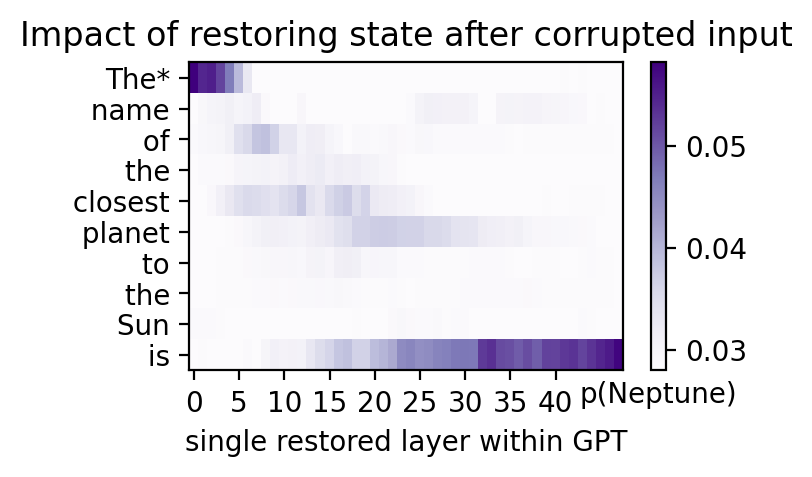

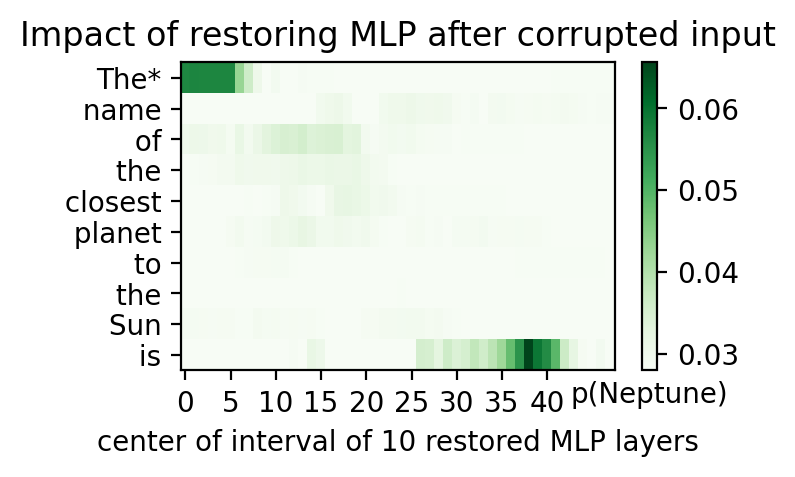

KeyboardInterrupt: 

In [19]:
plot_all_flow(mt, "The name of the closest planet to the Sun is", noise=noise_level)

Here we trace a few more factual statements from a file of test cases.

In [ ]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)

In [18]:
import json

caminho_arquivo_controle = "dsets/confirmacao.json" # O caminho dentro do ambiente do Colab

with open(caminho_arquivo_controle, 'r', encoding='utf-8') as f:
    dados_controle = json.load(f)

print(f"Arquivo '{caminho_arquivo_controle}' carregado com {len(dados_controle)} fatos.")

Arquivo 'dsets/confirmacao.json' carregado com 25 fatos.


--- Iniciando coleta de dados para a condição de CONTROLE ---


  0%|          | 0/25 [00:00<?, ?it/s]


Coleta concluída! 25 resultados coletados.
Heatmap médio calculado a partir de 25 fatos válidos.


/tmp/ipython-input-802568361.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  heatmap_padronizado[:tokens_a_copiar, :] = scores


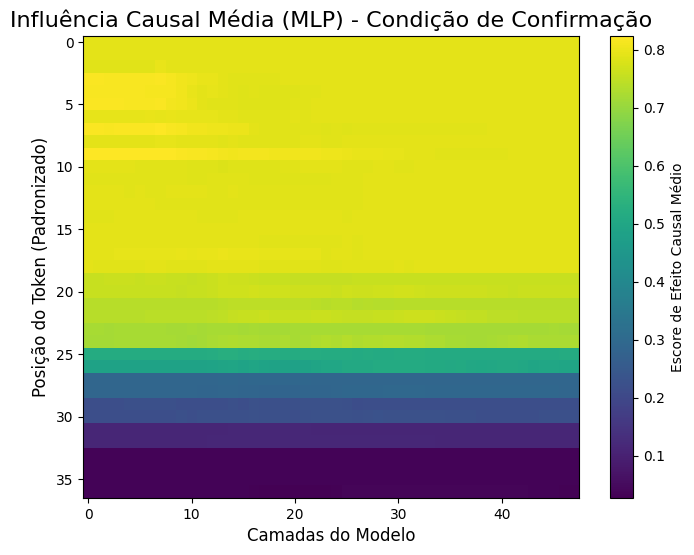

In [20]:
# --- CÉLULA 2: ANÁLISE COMPLETA (COLETA + MÉDIA + PLOT) ---
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm # Use tqdm.notebook para uma barra de progresso mais bonita

# --- 1. COLETA DE DADOS ---
print("--- Iniciando coleta de dados para a condição de CONTROLE ---")

lista_de_resultados = []
for fact in tqdm(dados_controle):
    # Chama a função que APENAS CALCULA
    result = calculate_hidden_flow(
        mt,
        prompt=fact["prompt"],
        subject=fact["subject"],
        noise=noise_level,
        kind="mlp"
    )
    lista_de_resultados.append(result)

print(f"\nColeta concluída! {len(lista_de_resultados)} resultados coletados.")

# --- 2. CÁLCULO DA MÉDIA ---
if lista_de_resultados:
    # Filtra apenas os resultados de predições corretas, se houver a chave
    scores_validos = [res['scores'] for res in lista_de_resultados if res.get('correct_prediction', True)]

    if scores_validos:
        # Padroniza os tamanhos (padding/cropping)
        max_tokens = max(s.shape[0] for s in scores_validos)
        num_camadas = scores_validos[0].shape[1]

        scores_padronizados = []
        for scores in scores_validos:
            heatmap_padronizado = np.zeros((max_tokens, num_camadas))
            tokens_a_copiar = scores.shape[0]
            heatmap_padronizado[:tokens_a_copiar, :] = scores
            scores_padronizados.append(heatmap_padronizado)

        heatmap_medio = np.mean(scores_padronizados, axis=0)
        print(f"Heatmap médio calculado a partir de {len(scores_validos)} fatos válidos.")

        # --- 3. PLOTAGEM DO HEATMAP MÉDIO ---
        plt.figure(figsize=(8, 6), dpi=100)
        plt.imshow(heatmap_medio, cmap='viridis', aspect='auto')
        plt.title("Influência Causal Média (MLP) - Condição de Confirmação", fontsize=16)
        plt.xlabel("Camadas do Modelo", fontsize=12)
        plt.ylabel("Posição do Token (Padronizado)", fontsize=12)
        plt.colorbar(label='Escore de Efeito Causal Médio')
        plt.show()
    else:
        print("Nenhum resultado de predição correta para analisar.")
else:
    print("Nenhum resultado foi coletado.")

In [24]:
# --- CÉLULA DE COLETA DE DADOS (APENAS CONTROLE) ---
import os
import numpy
import torch
from tqdm.notebook import tqdm

# --- DADOS ---
# Certifique-se de que a variável 'dados_controle' com seus 25 fatos está carregada
# dados_controle = [ ... ]

# --- PARÂMETROS ---
PASTA_RESULTADOS_BASE = "results_mlp"
NOME_CONDICAO = "confirmacao"

# --- COLETA E SALVAMENTO ---

# Cria a pasta específica para esta condição
caminho_resultados_condicao = os.path.join(PASTA_RESULTADOS_BASE, NOME_CONDICAO)
os.makedirs(caminho_resultados_condicao, exist_ok=True)

print(f"--- Iniciando coleta de dados para a condição: {NOME_CONDICAO.upper()} ---")
print(f"Os resultados serão salvos em: {caminho_resultados_condicao}")

for i, fact in enumerate(tqdm(dados_controle, desc=f"Processando {NOME_CONDICAO}")):

    # Caminho completo para o arquivo de resultado deste fato
    caminho_arquivo_resultado = os.path.join(caminho_resultados_condicao, f"fact_{i}.npz")

    # Pula se o resultado já existir (para continuar de onde parou)
    if os.path.exists(caminho_arquivo_resultado):
        print(f"  --> Fato {i+1} já existe. Pulando.")
        continue

    # Chama a função para calcular os scores
    result = calculate_hidden_flow(
        mt,
        prompt=fact["prompt"],
        subject=fact["subject"],
        noise=noise_level,
        kind="mlp"
    )

    # Adiciona os dados do fato ao dicionário de resultados para referência futura
    result['fact_details'] = fact

    # Converte os tensores da GPU para arrays NumPy na CPU
    numpy_result = {k: v.cpu().numpy() if isinstance(v, torch.Tensor) else v for k, v in result.items()}

    # Salva o dicionário completo no arquivo .npz
    numpy.savez(caminho_arquivo_resultado, **numpy_result)

    print(f"  Fato {i+1}/{len(dados_controle)} ('{fact['subject']}') concluído e salvo.")

print(f"\n--- Coleta para a Condição {NOME_CONDICAO.upper()} CONCLUÍDA! ---")

--- Iniciando coleta de dados para a condição: CONFIRMACAO ---
Os resultados serão salvos em: results_mlp/confirmacao


Processando confirmacao:   0%|          | 0/25 [00:00<?, ?it/s]

  --> Fato 1 já existe. Pulando.
  --> Fato 2 já existe. Pulando.
  --> Fato 3 já existe. Pulando.
  --> Fato 4 já existe. Pulando.
  Fato 5/25 ('largest animal') concluído e salvo.
  Fato 6/25 ('Mona Lisa') concluído e salvo.
  Fato 7/25 ('Star Wars') concluído e salvo.
  Fato 8/25 ('Queen') concluído e salvo.
  Fato 9/25 ('Harry Potter book series') concluído e salvo.
  Fato 10/25 ('Microsoft') concluído e salvo.
  Fato 11/25 ('Titanic') concluído e salvo.
  Fato 12/25 ('Japan') concluído e salvo.
  Fato 13/25 ('Giza pyramid complex') concluído e salvo.
  Fato 14/25 ('tulips and windmills') concluído e salvo.
  Fato 15/25 ('force') concluído e salvo.
  Fato 16/25 ('Aluminum') concluído e salvo.
  Fato 17/25 ('electric light bulb') concluído e salvo.
  Fato 18/25 ('Berlin Wall') concluído e salvo.
  Fato 19/25 ('first President of the United States') concluído e salvo.
  Fato 20/25 ('The Starry Night') concluído e salvo.
  Fato 21/25 ('natural selection') concluído e salvo.
  Fato 22/

--- Tabela de Escores Máximos Individuais ---
       condicao  fato_id  escore_maximo
0   Confirmacao        0       0.867188
1   Confirmacao        1       0.924805
2   Confirmacao        2       0.920410
3   Confirmacao        3       0.931152
4   Confirmacao        4       0.997070
5   Confirmacao        5       0.959473
6   Confirmacao        6       0.998047
7   Confirmacao        7       0.994629
8   Confirmacao        8       0.943848
9   Confirmacao        9       0.979980
10  Confirmacao       10       0.999023
11  Confirmacao       11       0.988281
12  Confirmacao       12       0.952148
13  Confirmacao       13       0.991699
14  Confirmacao       14       0.953125
15  Confirmacao       15       0.773438
16  Confirmacao       16       0.979492
17  Confirmacao       17       0.811035
18  Confirmacao       18       0.989746
19  Confirmacao       19       0.992188
20  Confirmacao       20       0.973633
21  Confirmacao       21       0.993652
22  Confirmacao       22       0.9

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


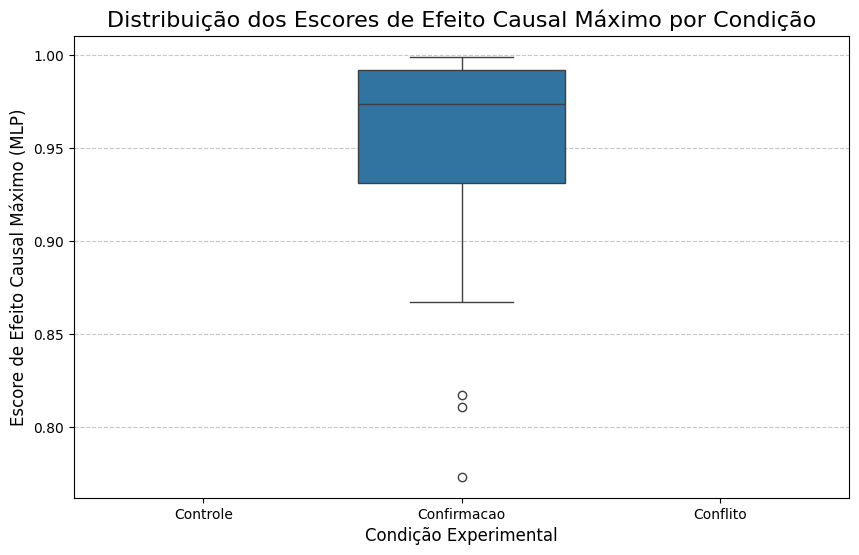

In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns # Para gráficos mais bonitos

# --- PARÂMETROS ---
NUM_FATOS = 25
PASTA_RESULTADOS = "results_mlp"
#CONDICOES = ["controle", "confirmacao", "conflito"]
CONDICOES = ["confirmacao"]

# --- FUNÇÃO PARA CARREGAR OS DADOS E EXTRAIR OS ESCORES ---
def extrair_escores_maximos(pasta_resultados, condicoes, num_fatos):
    """
    Carrega os arquivos .npz, extrai o escore máximo de cada um
    e retorna uma tabela (DataFrame) do pandas.
    """
    lista_de_escores = []

    for condicao in condicoes:
        caminho_pasta_condicao = os.path.join(pasta_resultados, condicao)
        if not os.path.exists(caminho_pasta_condicao):
            print(f"Aviso: Pasta não encontrada para a condição '{condicao}'. Pulando.")
            continue

        for i in range(num_fatos):
            caminho_arquivo = os.path.join(caminho_pasta_condicao, f"fact_{i}.npz")
            if os.path.exists(caminho_arquivo):
                with np.load(caminho_arquivo) as data:
                    if data.get('correct_prediction', True):
                        escore_maximo = np.max(data['scores'])
                        # subject = str(data['subject']) if 'subject' in data else f"Fato {i}"

                        lista_de_escores.append({
                            "condicao": condicao.capitalize(),
                            "fato_id": i,
                            # "subject": subject,
                            "escore_maximo": escore_maximo
                        })
            else:
                print(f"Aviso: Arquivo não encontrado para o fato {i} na condição '{condicao}'.")

    return pd.DataFrame(lista_de_escores)

# --- EXECUÇÃO DA ANÁLISE ---

# 1. Extrai todos os escores e cria a tabela
df_resultados = extrair_escores_maximos(PASTA_RESULTADOS, CONDICOES, NUM_FATOS)

if not df_resultados.empty:
    print("--- Tabela de Escores Máximos Individuais ---")
    print(df_resultados.to_string()) # .to_string() para mostrar a tabela inteira

    print("\n" + "="*50 + "\n")

    # 2. Calcula as médias e outras estatísticas descritivas
    print("--- Estatísticas Descritivas por Condição ---")
    estatisticas = df_resultados.groupby('condicao')['escore_maximo'].describe()
    print(estatisticas)

    print("\n" + "="*50 + "\n")

    # 3. Visualização (Gráfico de Barras ou Boxplot)
    print("--- Visualização dos Resultados ---")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_resultados, x='condicao', y='escore_maximo', order=['Controle', 'Confirmacao', 'Conflito'])
    plt.title('Distribuição dos Escores de Efeito Causal Máximo por Condição', fontsize=16)
    plt.xlabel('Condição Experimental', fontsize=12)
    plt.ylabel('Escore de Efeito Causal Máximo (MLP)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("Nenhum dado encontrado para análise. Verifique as pastas de resultados.")

--- Gerando heatmaps individuais para os 5 primeiros fatos de CONTROLE (foco na MLP) ---

Analisando o fato: 'The detective who lives at 221B Baker Street is Sherlock'


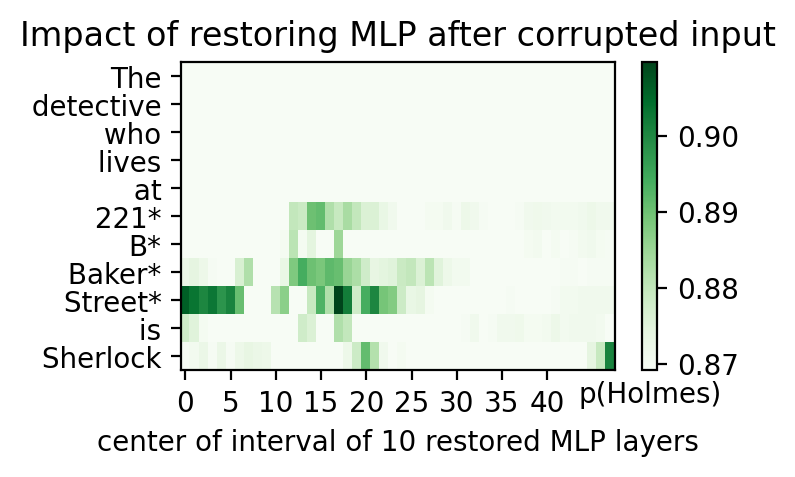


Analisando o fato: 'The organ responsible for pumping blood through the body is the'


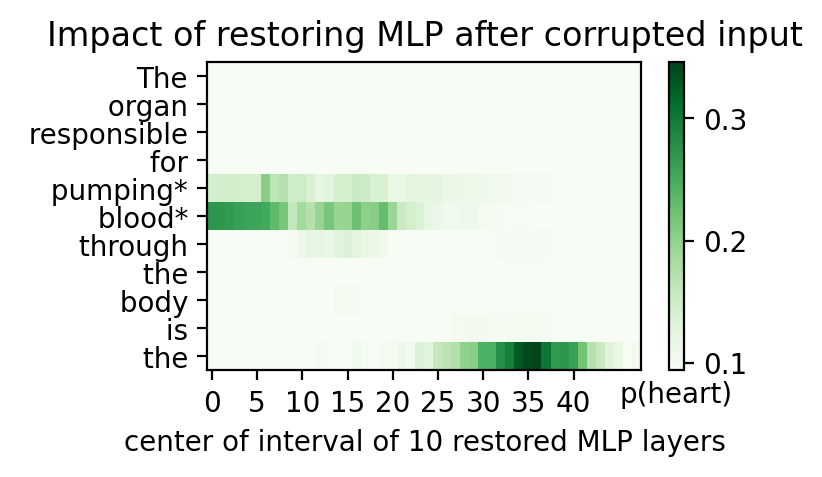


Analisando o fato: 'The search engine Google is owned by'


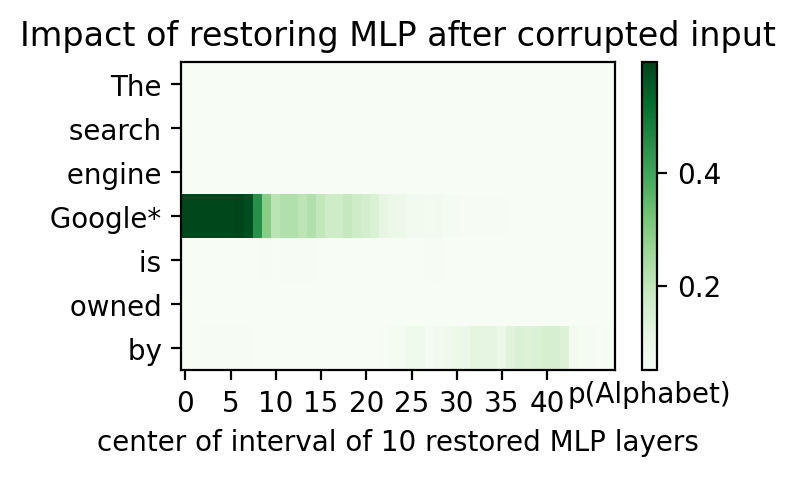


Analisando o fato: 'The river Nile flows into the'


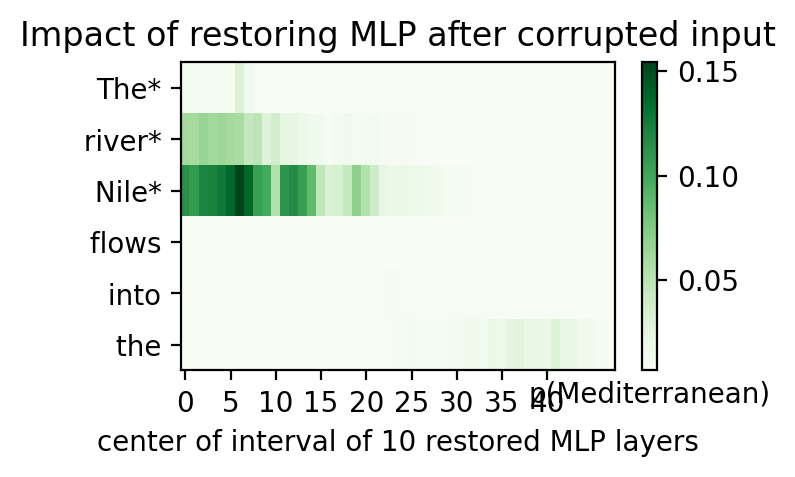

In [48]:
# --- CÉLULA DE ANÁLISE EXPLORATÓRIA (CASO A CASO) ---
import logging
# Vamos analisar os 5 primeiros fatos da sua condição de CONTROLE
# A função plot_hidden_flow é chamada para gerar o gráfico da MLP para cada um
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
print("--- Gerando heatmaps individuais para os 5 primeiros fatos de CONTROLE (foco na MLP) ---")

for fact in dados_controle[21:25]:  # Pega os 5 primeiros fatos
    print(f"\nAnalisando o fato: '{fact['prompt']}'")

    # Usamos a função plot_hidden_flow, especificando kind="mlp"
    plot_hidden_flow(
        mt,
        prompt=fact["prompt"],
        subject=fact["subject"],
        noise=noise_level,
        kind="mlp"  # <--- Foco exclusivo na MLP
    )